# The Problem
This notebook demonstrates how to use PyTorch to predict housing prices from various neighborhood and demographic features using a supervised machine learning approach called regression. The core goal is to train a model that can estimate the median house value in a California district based on features like population density, median income, and proximity to the ocean. This is a real-world regression problem, where the output is a continuous value rather than a class label.

# The Dataset
We use the California Housing dataset, a well-known benchmark regression dataset built into sklearn. It contains around 20,000 observations from the 1990 California census, with 8 input features per row (such as average income, number of rooms, and location-based metrics). The target variable is the median house value for each district, expressed in hundreds of thousands of dollars. This dataset is large enough to demonstrate real-world model behavior while still being small enough to train quickly.

# ⚖️ Feature Scaling
Before training the model, we scale the input features using standardization, which transforms each feature to have a mean of 0 and a standard deviation of 1. This is important because the original features (e.g., median income, average number of rooms, population) can have very different numerical ranges. Without scaling, features with larger ranges could dominate the learning process, causing the model to converge slowly or get stuck in suboptimal states. Standardizing the data ensures that all input features contribute more equally during training, and it also helps gradient-based optimizers like Adam converge more effectively. Scaling is performed using StandardScaler from sklearn, applied separately to the training and test sets.

In [5]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch, torch.nn as nn, torch.optim as optim
import pandas as pd

# Load data
X, y = fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# What is Target?
# The value you're trying to predict — in this dataset, 
# it's the median house value for a block group in California, 
# measured in hundreds of thousands of dollars.
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['Target'] = data.target
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


<function matplotlib.pyplot.show(close=None, block=None)>

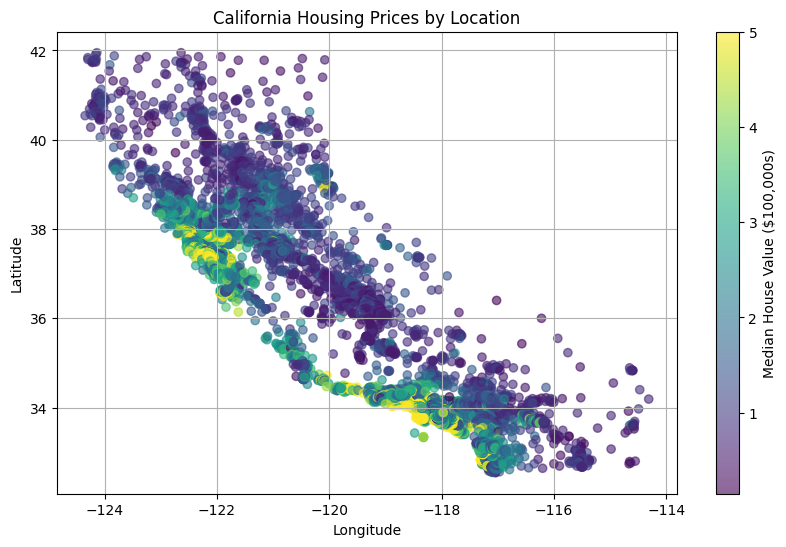

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 7], X[:, 6], c=y, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Median House Value ($100,000s)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('California Housing Prices by Location')
plt.grid(True)
plt.show

# ⚠️ Outliers and Their Impact on Modeling
Outliers are data points that differ significantly from the majority of observations, often due to measurement errors, rare events, or natural variability. In regression tasks like housing price prediction, outliers can disproportionately influence the model by skewing the learned relationships between features and targets. This can lead to poor generalization, where the model fits these extreme points at the expense of overall accuracy. Moreover, outliers can distort visualizations such as pair plots, making it difficult to discern true correlations and patterns in the data. Removing or properly handling outliers helps build more reliable, stable models and improves the interpretability of exploratory data analysis.

---

### 📏 Z-score Method for Outlier Detection

The **Z-score method** identifies outliers by measuring how many standard deviations a data point is from the mean of its feature distribution. The Z-score for a value $x$ is calculated as:

$$
z = \frac{x - \mu}{\sigma}
$$

where:

* $\mu$ is the mean of the feature,
* $\sigma$ is the standard deviation of the feature.

If the absolute value of the Z-score is greater than a threshold (commonly 3), the data point is considered an outlier.

**Steps:**

* Compute the Z-score for every feature of each data point.
* Remove any points where **any feature’s** absolute Z-score exceeds the threshold.
* This filters out extreme values that could skew model training or data visualization.

This method works best when the data is roughly normally distributed and is good at detecting global outliers far from the central data cluster.

Original dataset size: 20640
Filtered dataset size: 19798


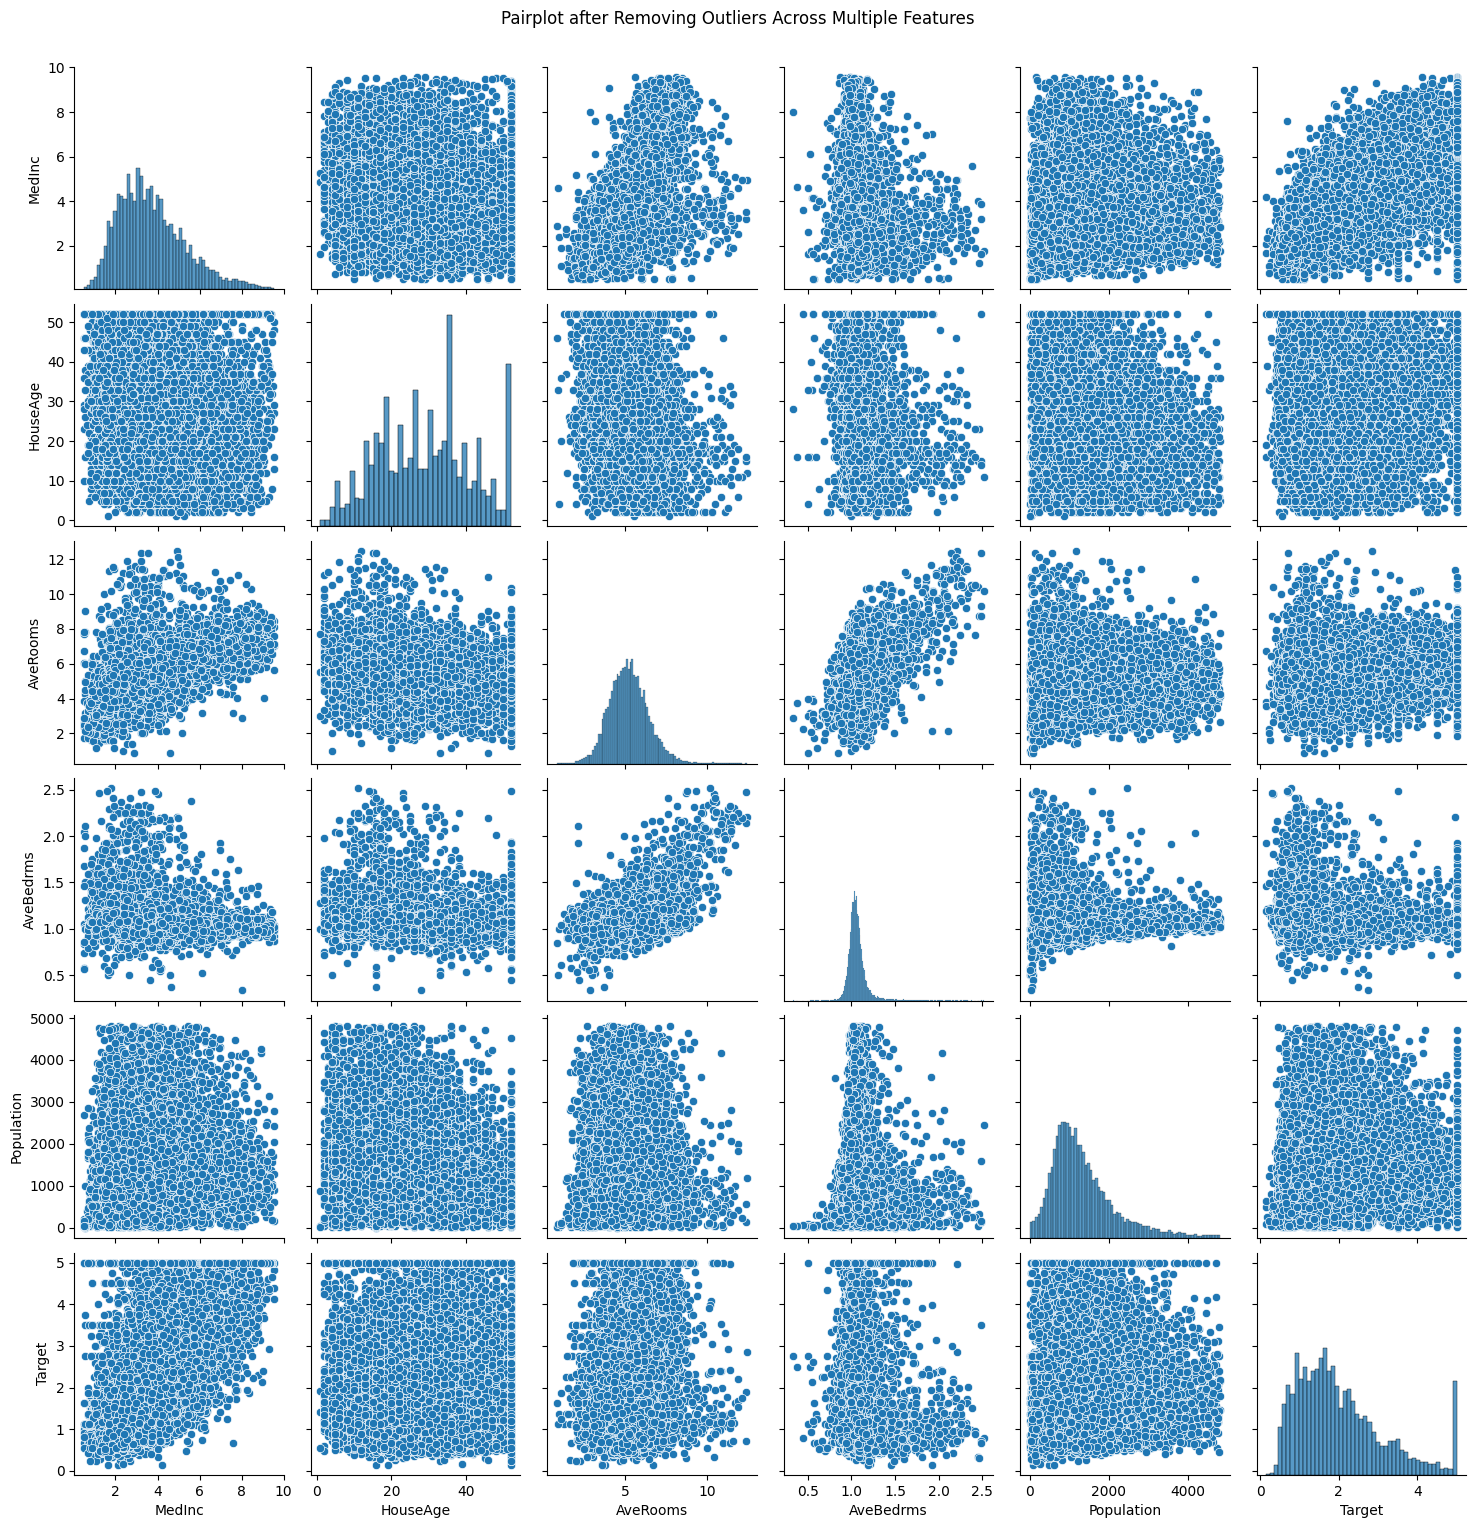

In [8]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['Target'] = data.target

# Select features you want to include in the pairplot
features_to_plot = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'Target']

# Calculate Z-scores for these features
z_scores = np.abs(stats.zscore(df[features_to_plot]))

# Keep only rows where all selected features have z-score < 3
df_filtered = df[(z_scores < 3).all(axis=1)]

print(f"Original dataset size: {df.shape[0]}")
print(f"Filtered dataset size: {df_filtered.shape[0]}")

# Plot pairplot with filtered data
sns.pairplot(df_filtered[features_to_plot], diag_kind='hist')
plt.suptitle('Pairplot after Removing Outliers Across Multiple Features', y=1.02)
plt.show()

# Converting to Tensors
After preprocessing the dataset (splitting into training and test sets and normalizing the input features), the data is converted into PyTorch tensors, which are the core data structure used in PyTorch for model training and inference. Tensors are similar to NumPy arrays but enable GPU acceleration and automatic gradient tracking, which are essential for deep learning. Both the input features and the target values are converted into floating-point tensors so they can be processed by the neural network.

In [9]:
# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.reshape(-1,1), dtype=torch.float32)

# Simple 2-Layer Network, MSELoss, and Adam Optimizer
The model is a basic fully connected feedforward neural network with two hidden layers. The first layer maps the 8 input features to 64 neurons, followed by a ReLU activation and another layer of 32 neurons. The final output layer produces a single value: the predicted house price. The loss function used is Mean Squared Error (MSE), which measures the average squared difference between predicted and actual prices—a standard choice for regression problems. We use the Adam optimizer, a widely used algorithm that adapts the learning rate during training for faster and more stable convergence.

In [10]:
# Simple 2-layer network
model = nn.Sequential(nn.Linear(X_train.shape[1], 64),
                      nn.ReLU(),
                      nn.Linear(64, 1))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training for 100 Epochs
During training, the model goes through 100 full passes (epochs) over the training data. For each epoch, the model makes predictions, compares them to the actual target values using the loss function, and updates its internal weights using backpropagation and gradient descent. Over time, the model learns patterns in the data that minimize the loss. The training loss is recorded at each epoch to visualize how well the model is learning. A steadily decreasing loss suggests the model is improving.

In [11]:
# Train
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.4f}")

/home/mtrottie/code/RecommenderSystems/.env/lib/python3.12/site-packages/torch/autograd/graph.py:824: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Loss 5.8000
Epoch 10, Loss 1.4280
Epoch 20, Loss 0.8569
Epoch 30, Loss 0.7158
Epoch 40, Loss 0.5809
Epoch 50, Loss 0.5220
Epoch 60, Loss 0.4798
Epoch 70, Loss 0.4510
Epoch 80, Loss 0.4315
Epoch 90, Loss 0.4172


# Evaluation
Once training is complete, the model is evaluated on the test dataset, which it has never seen before. We calculate two metrics: Mean Squared Error (MSE) and R² (coefficient of determination). MSE gives us an average measure of prediction error, while R² tells us how well the model explains the variance in the target variable. Finally, we plot predicted values versus actual values to visually inspect how well the model is performing—points close to the diagonal line indicate accurate predictions.

In [12]:
# Evaluate
with torch.no_grad():
    preds = model(X_test)
    mse = criterion(preds, y_test).item()
print("Test MSE:", mse)

Test MSE: 0.42094072699546814


In [13]:
# Example: Predict house price given custom input
def predict_price(features_dict):
    input_order = data.feature_names
    input_values = [features_dict.get(key, 0) for key in input_order]
    
    input_scaled = scaler.transform([input_values])
    input_tensor = torch.tensor(input_scaled, dtype=torch.float32)
    
    model.eval()
    with torch.no_grad():
        predicted = model(input_tensor).item()
    
    print(f"Predicted Median House Price: ${predicted * 100000:.2f}")

# Try it with a sample
example_features = {
    'MedInc': 5.0,       # median income (10k USD)
    'HouseAge': 20.0,    # median house age
    'AveRooms': 6.0,
    'AveBedrms': 1.0,
    'Population': 1000,
    'AveOccup': 3.0,
    'Latitude': 37.0,
    'Longitude': -122.0
}

predict_price(example_features)

import ipywidgets as widgets
from IPython.display import display, clear_output

# Define sliders for each feature
sliders = {
    'MedInc': widgets.FloatSlider(value=5.0, min=0, max=15, step=0.1, description='MedInc'),
    'HouseAge': widgets.FloatSlider(value=20.0, min=1, max=50, step=1, description='HouseAge'),
    'AveRooms': widgets.FloatSlider(value=6.0, min=1, max=20, step=0.5, description='AveRooms'),
    'AveBedrms': widgets.FloatSlider(value=1.0, min=0, max=5, step=0.1, description='AveBedrms'),
    'Population': widgets.FloatSlider(value=1000, min=100, max=50000, step=100, description='Population'),
    'AveOccup': widgets.FloatSlider(value=3.0, min=0.5, max=10, step=0.1, description='AveOccup'),
    'Latitude': widgets.FloatSlider(value=37.0, min=32, max=42, step=0.1, description='Latitude'),
    'Longitude': widgets.FloatSlider(value=-122.0, min=-125, max=-114, step=0.1, description='Longitude'),
}

output = widgets.Output()

def on_slider_change(change):
    with output:
        clear_output(wait=True)
        features = [sliders[name].value for name in data.feature_names]
        scaled = scaler.transform([features])
        input_tensor = torch.tensor(scaled, dtype=torch.float32)
        model.eval()
        with torch.no_grad():
            pred = model(input_tensor).item()
        print(f"🏠 Predicted Median House Price: ${pred * 100000:.2f}")

for slider in sliders.values():
    slider.observe(on_slider_change, names='value')

display(widgets.VBox(list(sliders.values())))
display(output)

# Show prediction on load
on_slider_change(None)

Predicted Median House Price: $280826.71


Output()